# Asking and Answering Questions on Stack Overflow
Stack Overflow has released official [How do I ask a good question?](https://stackoverflow.com/help/how-to-ask) and [How do I write a good answer?](https://stackoverflow.com/help/how-to-answer) guides.

Why do we care about the quality of the questions asked? Where does that put the pedagogical "There is no such thing as a bad question?"

Although there is an educational aspect to Stack Overflow, at the end of the day, it is a question and answer forum for developers to get and give help. If you are asking for help, you want to maximize your chances of getting it. If you are helping, you want to maximize your chances of being effective at helping. In this context, we could rephrase "good" questions to be questions likely to be answered, and "good" answers to be answers likely to be accepted.

Stack Overflow has the feature that

> Sometimes users encounter the following message when posting a question: 
>> 'This post does not meet our quality standards.'

>If you see this message, then your question was automatically blocked by the server. All new questions are subjected to a "minimum quality" filter that checks for some basic indicators of a good, complete question. Check to make sure that your question has the following:
A clear title.
A reasonable explanation of what your question is. Add as much detail as you can.
Any background research you've tried but wasn't enough to solve your problem.
Correct use of English spelling and grammar to the best of your ability.

However, everything they list above is quite subjective. Let's explore what features correlate with the votes and answers for a question.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

Let's read in the processed data by Text\ Processing.ipynb

In [2]:
Questions = pd.read_csv('LemmatizedQuestions.csv', encoding="ISO-8859-1")
Answers = pd.read_csv('LemmatizedAnswers.csv', encoding="ISO-8859-1")
Tags = pd.read_csv('pythonquestions/Tags.csv', encoding="ISO-8859-1")
Tags.columns = ['TID', 'Tag']

In [3]:
print(Questions.shape)
Questions.head()

(607282, 8)


,QID,QuestionUserId,QuestionCreateDate,QuestionScore,QuestionTitle,QuestionBody,QuestionTitleAndBody,QuestionTitleAndBodyLemmatized
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...,How can I find the full path to a font from it...,"['How', 'can', 'I', 'find', 'the', 'full', 'pa..."
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...,Get a preview JPEG of a PDF on Windows? <p>I h...,"['Get', 'a', 'preview', 'JPEG', 'of', 'a', 'PD..."
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...,Continuous Integration System for a Python Cod...,"['Continuous', 'Integration', 'System', 'for',..."
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...,cx_Oracle: How do I iterate over a result set?...,"['cx_Oracle', ':', 'How', 'do', 'I', 'iterate'..."
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...,Using 'in' to match an attribute of Python obj...,"['Using', ""'in"", ""'"", 'to', 'match', 'an', 'at..."


In [4]:
print(Answers.shape)
Answers.head()

(987122, 7)


,AID,AnswerUserId,AnswerCreateDate,ParentId,AnswerScore,AnswerBody,AnswerBodyLemmatized
0,497,50.0,2008-08-02T16:56:53Z,469,4,<p>open up a terminal (Applications-&gt;Utilit...,"['open', 'up', 'a', 'terminal', '(', 'Applicat..."
1,518,153.0,2008-08-02T17:42:28Z,469,2,<p>I haven't been able to find anything that d...,"['I', 'have', ""n't"", 'been', 'able', 'to', 'fi..."
2,536,161.0,2008-08-02T18:49:07Z,502,9,<p>You can use ImageMagick's convert utility f...,"['You', 'can', 'use', 'ImageMagick', ""'s"", 'co..."
3,538,156.0,2008-08-02T18:56:56Z,535,23,<p>One possibility is Hudson. It's written in...,"['One', 'possibility', 'is', 'Hudson', '.', 'I..."
4,541,157.0,2008-08-02T19:06:40Z,535,20,"<p>We run <a href=""http://buildbot.net/trac"">B...","['We', 'run', 'Buildbot', '-', 'Trac', 'at', '..."


In [5]:
print(Tags.shape)
Tags.head()

(1885078, 2)


,TID,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


In [6]:
print(Questions.isnull().sum())
print(Answers.isnull().sum())
print(Tags.isnull().sum())

QID                                  0
QuestionUserId                    6212
QuestionCreateDate                   0
QuestionScore                        0
QuestionTitle                        0
QuestionBody                         0
QuestionTitleAndBody                 0
QuestionTitleAndBodyLemmatized       0
dtype: int64
AID                        0
AnswerUserId            5367
AnswerCreateDate           0
ParentId                   0
AnswerScore                0
AnswerBody                 0
AnswerBodyLemmatized       0
dtype: int64
TID      0
Tag    443
dtype: int64


Looks like this data is pretty clean. The only nulls are for users (probably users that have deleted their accounts since posting), and tags (since these are optional).

### Question 1: How many users are engaged on Q, A, & Q&A?

In [7]:
User_id_inQ = Questions['QuestionUserId'].unique()
User_id_inA = Answers['AnswerUserId'].unique()
User_id_inBoth=set(User_id_inQ).intersection(User_id_inA)

In [8]:
print(str(len(User_id_inQ)) + ' users posting questions')
print(str(len(User_id_inA)) + ' users posting answers')
print(str(len(User_id_inBoth)) + ' users posting both')

213928 users posting questions
149177 users posting answers
63779 users posting both


## So, what makes a good question?
Specifically "to improve your chances of getting an answer", Stack Overflow suggests
- Search and research before posting
- Have an informative title
- Include any error messages, key APIs, or unusual circumstances
- Introduce the problem before posting any code
- "Not all questions benefit from including code. But if your problem is with code you've written, you should include some."
- Include all relevant tags
- Proofread

Let's examine whether or not including error messages (and the closely related traceback), code, and tags truly improve a question's chances of getting an answer.

### Question 2: How many questions contain Python-formatted errors?

In [9]:
Questions['HasError'] = Questions['QuestionBody'].str.contains("[A-Z][a-z]+Error:\s")

In [10]:
print(str(Questions['HasError'].sum() / Questions['HasError'].count()) + " of questions have a full Python-formatted error message")

0.14075997641952173 of questions have a full Python-formatted error message


### Question 3: How many questions contain Python-formatted tracebacks?

In [11]:
Questions['HasTraceback'] = Questions['QuestionBody'].str.contains("Traceback \(most recent call last\):")

In [12]:
print(str(Questions['HasTraceback'].sum() / Questions['HasTraceback'].count()) + " of questions have a full Python-formatted traceback")

0.06771977433877506 of questions have a full Python-formatted traceback


### Question 4: How many questions contain code?

In [13]:
Questions['HasMultiLineCode'] = Questions['QuestionBody'].str.contains("<code>.*\n.*</code>")

In [14]:
print(str(Questions['HasMultiLineCode'].sum() / Questions['HasMultiLineCode'].count()) + " of questions have multi line code")

0.23783514084066382 of questions have multi line code


### Overall average number of answers per question

In [80]:
# Questions.drop('NumAnswers', axis=1, inplace=True)
Questions.columns

Index(['QID', 'QuestionUserId', 'QuestionCreateDate', 'QuestionScore',
       'QuestionTitle', 'QuestionBody', 'QuestionTitleAndBody',
       'QuestionTitleAndBodyLemmatized', 'HasError', 'HasTraceback',
       'HasMultiLineCode', 'NumTags', 'NumAnswers'],
      dtype='object')

In [77]:
QA = Questions.merge(Answers, how='left', left_on='QID', right_on='ParentId')

In [78]:
AnswersPerQuestion = QA.groupby('QID').count().iloc[:,[0]].reset_index()
AnswersPerQuestion.columns = ['QID', 'NumAnswers']
Questions = Questions.merge(AnswersPerQuestion, how='left', on='QID')
Questions[['NumAnswers']] = Questions[['NumAnswers']].fillna(0)

In [81]:
QA = Questions.merge(Answers, how='left', left_on='QID', right_on='ParentId')

In [17]:
total_average_answers = AnswersPerQuestion['NumAnswers'].sum() / AnswersPerQuestion['NumAnswers'].count()
print('total average answers ' + str(total_average_answers))

total average answers 1.7151290504246792


### Overall answer rate per question

In [87]:
Questions.groupby('NumAnswers').count().head()

,QID,QuestionUserId,QuestionCreateDate,QuestionScore,QuestionTitle,QuestionBody,QuestionTitleAndBody,QuestionTitleAndBodyLemmatized,HasError,HasTraceback,HasMultiLineCode,NumTags
NumAnswers,,,,,,,,,,,,
0,6212,0,6212,6212,6212,6212,6212,6212,6212,6212,6212,6212
1,357824,357824,357824,357824,357824,357824,357824,357824,357824,357824,357824,357824
2,139729,139729,139729,139729,139729,139729,139729,139729,139729,139729,139729,139729
3,57905,57905,57905,57905,57905,57905,57905,57905,57905,57905,57905,57905
4,24561,24561,24561,24561,24561,24561,24561,24561,24561,24561,24561,24561


In [44]:
AnswersPerQuestion.groupby('NumAnswers').count().sum()

QID    607282
dtype: int64

In [50]:
total_answer_rate = (Questions.shape[0] - AnswersPerQuestion.groupby('NumAnswers').count().iloc[0,0]) / Questions.shape[0]
print('total answer rate ' + str(total_answer_rate))

total answer rate 0.9897708148767789


### Question 6: Do questions with errors have more or less than 1.7 answers?

In [51]:
AnswersPerQuestionWithError = Questions[Questions['HasError']].groupby('QID').count()
hasError_average_answers = AnswersPerQuestionWithError['AnswerCreateDate'].sum() / len(AnswersPerQuestionWithError['AnswerCreateDate'])
print('error average answers ' + str(hasError_average_answers))
hasError_answer_rate = (Questions.shape[0] - AnswersPerQuestion.groupby('NumAnswers').count().iloc[0,0]) / Questions.shape[0]
print('total answer rate ' + str(hasError_answer_rate))

error average answers 1.4572361109486318


### Question 7: Do questions with tracebacks have more or less than 1.83 answers?

In [52]:
AnswersPerQuestionWithTraceback = QA[QA['HasTraceback']].groupby('QID').count()
hasTraceback_average_answers = AnswersPerQuestionWithTraceback['AnswerCreateDate'].sum() / len(AnswersPerQuestionWithTraceback['AnswerCreateDate'])
print('traceback average answers ' + str(hasError_average_answers))

traceback average answers 1.4572361109486318


### Question 8: Do questions with errors and tracebacks have more or less than 1.7 answers?

In [53]:
AnswersPerQuestionWithErrorAndTraceback = QA[(QA['HasError'] & QA['HasTraceback'])].groupby('QID').count()
hasErrorAndTraceback_average_answers = AnswersPerQuestionWithErrorAndTraceback['AnswerCreateDate'].sum() / len(AnswersPerQuestionWithErrorAndTraceback['AnswerCreateDate'])
print('error traceback average answers ' + str(hasErrorAndTraceback_average_answers))

error traceback average answers 1.4304368902623765


### Question 9: Do questions with code have more or less than 1.7 answers?

In [25]:
AnswersPerQuestionWithMultiLineCode = QA[QA['HasMultiLineCode']].groupby('QID').count()
hasMultiLineCode_average_answers = AnswersPerQuestionWithMultiLineCode['AnswerCreateDate'].sum() / len(AnswersPerQuestionWithError['AnswerCreateDate'])
print('multiline code average answers ' + str(hasMultiLineCode_average_answers))

multiline code average answers 3.270530756087142


### Overall average number of tags per question

In [26]:
QT = Questions.merge(Tags, how='left', left_on='QID', right_on='TID')

In [27]:
TagsPerQuestion = QT.groupby('QID').count().iloc[:,[0]].reset_index()
TagsPerQuestion.columns = ['QID', 'NumTags']
Questions = Questions.merge(TagsPerQuestion, how='left', on='QID')
Questions[['NumTags']] = Questions[['NumTags']].fillna(0)

In [28]:
TagsPerQuestion.head()

,QID,NumTags
0,469,4
1,502,4
2,535,3
3,594,5
4,683,3


In [29]:
total_average_tags = TagsPerQuestion['NumTags'].sum() / TagsPerQuestion['NumTags'].count()
print('total average tags ' + str(total_average_tags))

total average tags 3.0744991618391455


/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


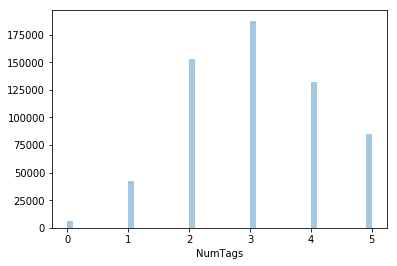

In [30]:
sns.distplot(Questions.NumTags, kde=False)

### Question 10: Do number of tags correspond to number of answers?

In [31]:
Questions.groupby('NumTags').sum()[['NumAnswers']] / Questions.groupby('NumTags').count()[['NumAnswers']]

,NumAnswers
NumTags,
0,0.000000
1,2.231335
2,1.805110
3,1.695782
4,1.636211
5,1.585181


This is also rather counterintuitive. Those with fewer tags had more answers (compared to the overall average of 1.83 answers). Stack Overflow uses tags to show questions to users on the STO homepage. Perhaps people don't go on the homepage much?

Next steps: explore not "Number of Answers" but "Percent Answered"
    explore what percentage of answers answer what percent of users